# Project 5 — 0/1 Knapsack with Simmulated Annealing


## Overview
In this project you will implement a **Knapsack class** capable of reading `.knp` instance files, generating a **greedy ratio-based initial solution**, and applying a **Simulated Annealing** metaheuristic to improve that solution.

---

## Reminder: what is the knapsack problem?

You have a backpack (the **knapsack**) with a maximum **capacity** (how much weight it can carry). There are `n` items; each item `i` has a **weight** `w[i]` and a **value** `v[i]`. Your goal is to choose items that **maximize total value** without exceeding the capacity.




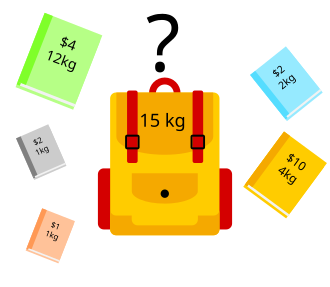

https://en.wikipedia.org/wiki/Knapsack_problem

### 0/1 (binary) vs. fractional knapsack
- **0/1 (binary) knapsack**: each item must be either **taken completely** (`1`) or **not taken** (`0`). This version is **computationally hard** (NP-hard), so we don’t have a simple, always-fast method that guarantees the optimal solution for large `n`.
- **Fractional knapsack**: we’re allowed to take **fractions** of items (e.g., 30% of an item). In this setting there *is* a simple, optimal approach: a **greedy** method based on “value per unit weight.”



## 1 File Format (`.knp`)

Each instance file follows this exact structure:

```
<nothing on this line>
n
c

p_1 w_1
p_2 w_2
...
p_n w_n
```

Where:
- `n` = number of items  
- `c` = knapsack capacity  
- `p_i` = profit (value) of item `i`  
- `w_i` = weight of item `i`  

Blank lines must be handled properly.

## 2 The `KnapsackSA` Class

You must implement a class with the following attributes at minimum:

- `self.filename`
- `self.n`
- `self.capacity`
- `self.values` (list)
- `self.weights` (list)

Your constructor method `__initi__` must:
- Read the `.knp` file  
- Extract `n`, `capacity`, `values`, and `weights`  



## 3. Greedy Initial Solution

Your class should have a method named `greedy_initial_solution()`, that generates an initial solution.

### Method: `greedy_initial_solution()`

This method must:
1. Compute the ratio `value / weight` for every item  
2. Sort items in decreasing ratio order  
3. Add items greedily while respecting capacity  
4. Return:
   - A **binary vector** indicating selected items  
   - Total value  
   - Total weight  

This provides the **starting point** for simulated annealing (an improvement method).

## 4. Simulated Annealing

[Simmulated Annealing Wilkipedia](https://en.wikipedia.org/wiki/Simulated_annealing)

### Method Signature
```
simulated_annealing(self, T0, max_iter, time_limit, alpha)
```

### Parameters
- `T0`: initial temperature  
- `max_iter`: maximum number of iterations  
- `time_limit`: allowed runtime in seconds  
- `alpha`: Cooling rate, float value between 0 and 1 that determines how fast the temperature `T0` will decrease per iteration.

### What You Must Implement

#### 4.1 Solution Representation
Solutions are binary lists (`0` = item excluded, `1` = item included).

#### 4.2 Neighborhood
A neighbor is generated by:
- Choosing a random index
- Flipping its bit
- Ensuring the resulting solution is **feasible** (not overweight)

If infeasible, assign a penalty based on how much the weight of the solution exceeds the capacity.

#### 4.3 Objective Function
Compute:
- Total value  
- Total weight
- Capacity penalty  

#### 4.4 Acceptance Criterion

Let:
- `Δ = candidate_value - current_value`

Rules:
- If `Δ > 0`: accept always  
- If `Δ <= 0`: accept with probability  
  \\( e^{\Delta / T} \\)

Use a random number in `[0, 1]` to decide.

#### 4.5 Cooling Schedule
Use **geometric cooling**:
```
T = alpha * T
```
with `alpha` close to 1 (e.g., 0.99).

Stop if temperature becomes extremely small.

#### 4.6 Stopping Criteria

Stop when **any** of the following happens:
- Iterations reach `max_iter`
- Time limit is reached
- Temperature is too small

#### 4.7 Tracking the Best Solution
You must keep track of:
- `current_solution`
- `best_solution`
- `best_value`

Return the **best one found**, not the last one visited.

## 5. Expected Behavior

Example usage:

```python
ks = KnapsackSA("instance.knp")

initial_sol, initial_val, initial_weight = ks.greedy_initial_solution()

best_sol, best_val = ks.simulated_annealing(
    T0=100,
    max_iter=500,
    time_limit=300,  # in seconds
    alpha = 0.99
)
```

# Your code goes here

In [1]:
import numpy as np
import time

In [68]:
class KnapsackSA:
    def __init__(self, filename):
        self.filename = filename
        self.n = 0
        self.capacity = 0
        self.values = []
        self.weights = []
        self.read_instance()

        # Penalty multiplier = sum of all values
        self.delta_penalty = sum(self.values)

    # ---------------------------------------------------------
    # 1. READ INSTANCE
    # ---------------------------------------------------------
    def read_instance(self):
        with open(self.filename, "r", encoding="utf-8") as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        # Expected after removing blank lines:
        # lines[0] = n
        # lines[1] = capacity
        # lines[2:] = p_i w_i

        self.n = int(lines[0])
        self.capacity = int(lines[1])

        self.values = []
        self.weights = []

        for line in lines[2:]:
            p, w = line.split()
            self.values.append(int(p))
            self.weights.append(int(w))

    # ---------------------------------------------------------
    # 2. COMPUTE VALUE, WEIGHT + PENALTY
    # ---------------------------------------------------------
    def evaluate(self, solution):
        """
        Returns (objective_value, total_value, total_weight)

        The objective_value includes the penalty term if the
        solution is infeasible.
        """

        total_value = 0
        total_weight = 0

        for bit, v, w in zip(solution, self.values, self.weights):
            if bit == 1:
                total_value += v
                total_weight += w

        # If feasible, objective = total value
        if total_weight <= self.capacity:
            return total_value, total_value, total_weight

        # If infeasible → apply penalty:
        # penalty = delta * (capacity - weight)
        # Note: (capacity - weight) is negative if weight > capacity.
        excess = self.capacity - total_weight  # negative number
        penalty = self.delta_penalty * excess  # negative penalty

        penalized_objective = total_value + penalty
        return penalized_objective, total_value, total_weight

    # ---------------------------------------------------------
    # 3. GREEDY INITIAL SOLUTION
    # ---------------------------------------------------------
    def greedy_initial_solution(self):
        ratios = [(self.values[i] / self.weights[i], i) for i in range(self.n)]
        ratios.sort(reverse=True)

        solution = [0] * self.n
        remaining_capacity = self.capacity

        for ratio, idx in ratios:
            w = self.weights[idx]
            if w <= remaining_capacity:
                solution[idx] = 1
                remaining_capacity -= w

        obj, val, wt = self.evaluate(solution)
        return solution, val, wt

    def naive_zero(self):

      return [0]*self.n,0,0

    # ---------------------------------------------------------
    # 4. RANDOM NEIGHBOR (bit flip)
    # ---------------------------------------------------------
    def random_neighbor(self, solution):
        """Return a new solution with one bit flipped."""
        new_sol = solution.copy()
        # idx = random.randint(0, self.n - 1)
        idx = np.random.randint(0, self.n)
        new_sol[idx] = 1 - new_sol[idx]  # flip
        return new_sol

    # ---------------------------------------------------------
    # 5. SIMULATED ANNEALING
    # ---------------------------------------------------------
    def simulated_annealing(self, T0, max_iter, time_limit, alpha=0.99, verbose=False):
          """
          Simulated Annealing with penalty-based evaluation.

          Parameters:
              T0         - initial temperature
              max_iter   - maximum number of iterations
              time_limit - time limit in seconds
              alpha      - cooling rate (default 0.99)
              verbose    - if True, prints iteration logs
          """

          start_time = time.time()

          # --- Start from greedy solution
          #current, cur_val, cur_wt = self.greedy_initial_solution()
          current, cur_val, cur_wt = self.naive_zero()
          cur_obj, _, _ = self.evaluate(current)

          best = current.copy()
          best_obj = cur_obj
          best_val = cur_val

          T = T0
          iterations = 0

          while iterations < max_iter and (time.time() - start_time) < time_limit and T > 1e-6:

              # --- Generate neighbor
              candidate = self.random_neighbor(current)
              cand_obj, cand_val, cand_wt = self.evaluate(candidate)

              delta = cand_obj - cur_obj

              # --- Acceptance rules
              if delta > 0:
                  current = candidate
                  cur_obj = cand_obj
                  cur_val = cand_val
                  cur_wt = cand_wt
              else:
                  prob = np.exp(delta / T)
                  if np.random.rand() < prob:
                      current = candidate
                      cur_obj = cand_obj
                      cur_val = cand_val
                      cur_wt = cand_wt

              # --- Update best
              if cur_obj > best_obj:
                  best = current.copy()
                  best_obj = cur_obj
                  best_val = cur_val

              # --- Verbose printing
              if verbose:
                  elapsed = time.time() - start_time
                  print(
                      f"Iter: {iterations:6d} | "
                      f"Time: {elapsed:8.4f}s | "
                      f"Current Obj: {cur_obj:12.4f} | "
                      f"Best Obj: {best_obj:12.4f}"
                  )

              # --- Cooling
              T *= alpha
              iterations += 1

          return best, best_val

In [69]:
ks = KnapsackSA("s014.kp")

initial_sol, initial_val, initial_weight = ks.greedy_initial_solution()

print(f"Initial solution: {initial_sol}")
print(f"Initial value: {initial_val:,}")

Initial solution: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Initial value: 81,824


In [77]:
best_sol, best_val = ks.simulated_annealing(
    T0 = 1_000_000,
    max_iter = 200_000,
    time_limit = 300,  # in seconds
    alpha = 0.999,
    verbose = False
)

print(f"Improved solution: {best_sol}")
print(f"Improved value: {best_val}")

Improved solution: [0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Improved value: 74700


# optimal gurobi

In [41]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 94.1 MB/s eta 0:00:00


In [42]:
from gurobipy import GRB
import gurobipy as gp

In [63]:
n = ks.n
values = ks.values
weights = ks.weights
capacity = ks.capacity

m = gp.Model("Knapsack")

# -----------------------------------------------------
# 1. Decision variables
# -----------------------------------------------------
x = m.addVars(n, vtype=GRB.BINARY, name="x")

# -----------------------------------------------------
# 2. Objective: maximize total profit
# -----------------------------------------------------
m.setObjective(gp.quicksum(values[i] * x[i] for i in range(n)),
                GRB.MAXIMIZE)

# -----------------------------------------------------
# 3. Capacity constraint
# -----------------------------------------------------
m.addConstr(gp.quicksum(weights[i] * x[i] for i in range(n)) <= capacity,
            name="capacity")

<gurobi.Constr *Awaiting Model Update*>

In [64]:
# -----------------------------------------------------
# 4. Optimize
# -----------------------------------------------------
m.optimize()

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 200 columns and 200 nonzeros (Max)
Model fingerprint: 0x577e1fdb
Model has 200 linear objective coefficients
Variable types: 0 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [3e+00, 1e+03]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+04, 5e+04]
Found heuristic solution: objective 46504.000000
Presolve time: 0.00s
Presolved: 1 rows, 200 columns, 200 nonzeros
Variable types: 0 continuous, 200 integer (200 binary)

Root relaxation: objective 8.185374e+04, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  

In [66]:
# -----------------------------------------------------
# 5. Extract solution
# -----------------------------------------------------
selected_items = [int(x[i].X) for i in range(n)]
optimal_value = m.objVal

print(f"Selected items: {selected_items}")
print(f"Optimal value: {optimal_value:,}")

Selected items: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
Optimal value: 81,831.0
